# Long-term OPE Synthetic Simulation: Varying data sizes

In this notebook, we compare the estimation accuracy of four estimation methods with varying data sizes of the historical and short-term experiment datasets.

In [2]:
import time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state

from dataset import SyntheticDataset
from estimation import run_all

In [3]:
sns.set_theme(style='white')
method_list = ["long_term_experiment", "long_term_ci", "typical_ope_ips", "typical_ope_dr", "long_term_ope"]
legend = ["Long-term Experiment (Skyline)", "Long-term CI", "OPE (IPS)", "OPE (DR)", "LOPE (Ours)"]
palette = ['tab:grey', '#FF6437', '#509BF5', '#F037A5', '#4B917D', '#FFC864', '#C87D55', '#2D46B9', '#8C1932', '#9BF0E1']
y_label_dict = {
    "se": "MSE", "bias": "Squared Bias", "variance": "Variance", "selection": "% Right Selection",
    "norm_se": "Norm-MSE", "norm_bias": "Norm-Squared Bias", "norm_variance": "Norm-Variance",
    "rel_se": "Relative MSE", "rel_bias": "Relative Squared Bias", "rel_variance": "Relative Variance", "rel_selection": "Rel-% Right Selection"
}

In [4]:
### experiment configurations ###
n_sims = 1000 # number of simulation runs
n_actions = 30 # number of actions
x_dim = 5 # feature dimension
a_dim = 5 # action feature dimension
s_dim = 3 # short-term reward dimension (number of short-term metrics)
lambda_ = 0.5 # contribution of the short-term rewards in the expected long-term reward function
reward_std = 5.0 # level of noise on the long-term reward
reward_type = "continuous" # binary or continuous

beta, k, eps = 1, 3, 0.1 # define baseline and new policies
n_data_list = [200, 400, 600, 800, 1000] # experiment parameter range

In [ ]:
result_df_list = []
for n_data in n_data_list:
    dataset = SyntheticDataset(
        n_actions=n_actions, x_dim=x_dim, a_dim=a_dim, s_dim=s_dim, lambda_=lambda_,
        reward_type=reward_type, reward_std=reward_std,
    )
    true_value_of_baseline_policy = dataset.calc_policy_value_beta(beta=beta)
    true_value_of_new_policy = dataset.calc_policy_value_eps(k=k, eps=eps)
    is_new_policy_better = np.int(true_value_of_baseline_policy < true_value_of_new_policy)
    is_new_policy_better = is_new_policy_better - (1 - is_new_policy_better)
    print(f"base policy: {round(true_value_of_baseline_policy, 3)}, new policy: {round(true_value_of_new_policy, 3)}")

    estimated_baseline_policy_value_list, estimated_new_policy_value_list, estimated_comparison_list = [], [], []
    for _ in tqdm(range(n_sims), desc=f"n_data={n_data}..."):
        D_H = dataset.generate_dataset(n_data=n_data, beta=beta, k=k, eps=eps, baseline=True) # historical data generated by a baseline policy
        D_E_0 = dataset.generate_dataset(n_data, beta=beta, baseline=True) # short-term experiment data generated by a baseline policy
        D_E_1 = dataset.generate_dataset(n_data, k=k, eps=eps, baseline=False) # short-term experiment data generated by a new policy

        estimated_values_of_baseline, estimated_values_of_new_policy, estimated_comparison = run_all(D_H, [D_E_0, D_E_1])
        estimated_baseline_policy_value_list.append(estimated_values_of_baseline)
        estimated_new_policy_value_list.append(estimated_values_of_new_policy)
        estimated_comparison_list.append(estimated_comparison)

        ## summarize results
        result_df = (
            pd.concat([
                DataFrame(estimated_baseline_policy_value_list).stack(),
                DataFrame(estimated_new_policy_value_list).stack(),
                DataFrame(estimated_comparison_list).stack(),
            ], 1).reset_index(1).rename(columns={"level_1": "est", 0: "base_value", 1: "value", 2: "selection"})
        )
        result_df["n_data"] = n_data
        result_df["true_value"] = true_value_of_new_policy
        result_df["se"] = (result_df.value - true_value_of_new_policy) ** 2
        result_df["bias"] = 0
        result_df["variance"] = 0
        result_df["selection"] *= is_new_policy_better
        result_df["selection"] = result_df["selection"] == 1
        sample_mean = DataFrame(result_df.groupby(["est"]).mean().value).reset_index()
        for est_ in sample_mean["est"]:
            estimates = result_df.loc[result_df["est"] == est_, "value"].values
            mean_estimates = sample_mean.loc[sample_mean["est"] == est_, "value"].values
            mean_estimates = np.ones_like(estimates) * mean_estimates
            result_df.loc[result_df["est"] == est_, "bias"] = (true_value_of_new_policy - mean_estimates) ** 2
            result_df.loc[result_df["est"] == est_, "variance"] = (estimates - mean_estimates) ** 2
    result_df_list.append(result_df)
result_df = pd.concat(result_df_list).reset_index(level=0)

base policy: 0.796, new policy: 1.311


n_data=200...: 100%|##########| 1000/1000 [13:12<00:00,  1.26it/s]


base policy: 0.794, new policy: 1.322


n_data=400...: 100%|##########| 1000/1000 [24:16<00:00,  1.46s/it]


base policy: 0.801, new policy: 1.317


n_data=600...: 100%|##########| 1000/1000 [36:06<00:00,  2.17s/it]


base policy: 0.791, new policy: 1.325


n_data=800...:  72%|#######1  | 717/1000 [34:03<13:30,  2.86s/it]

## Visualization

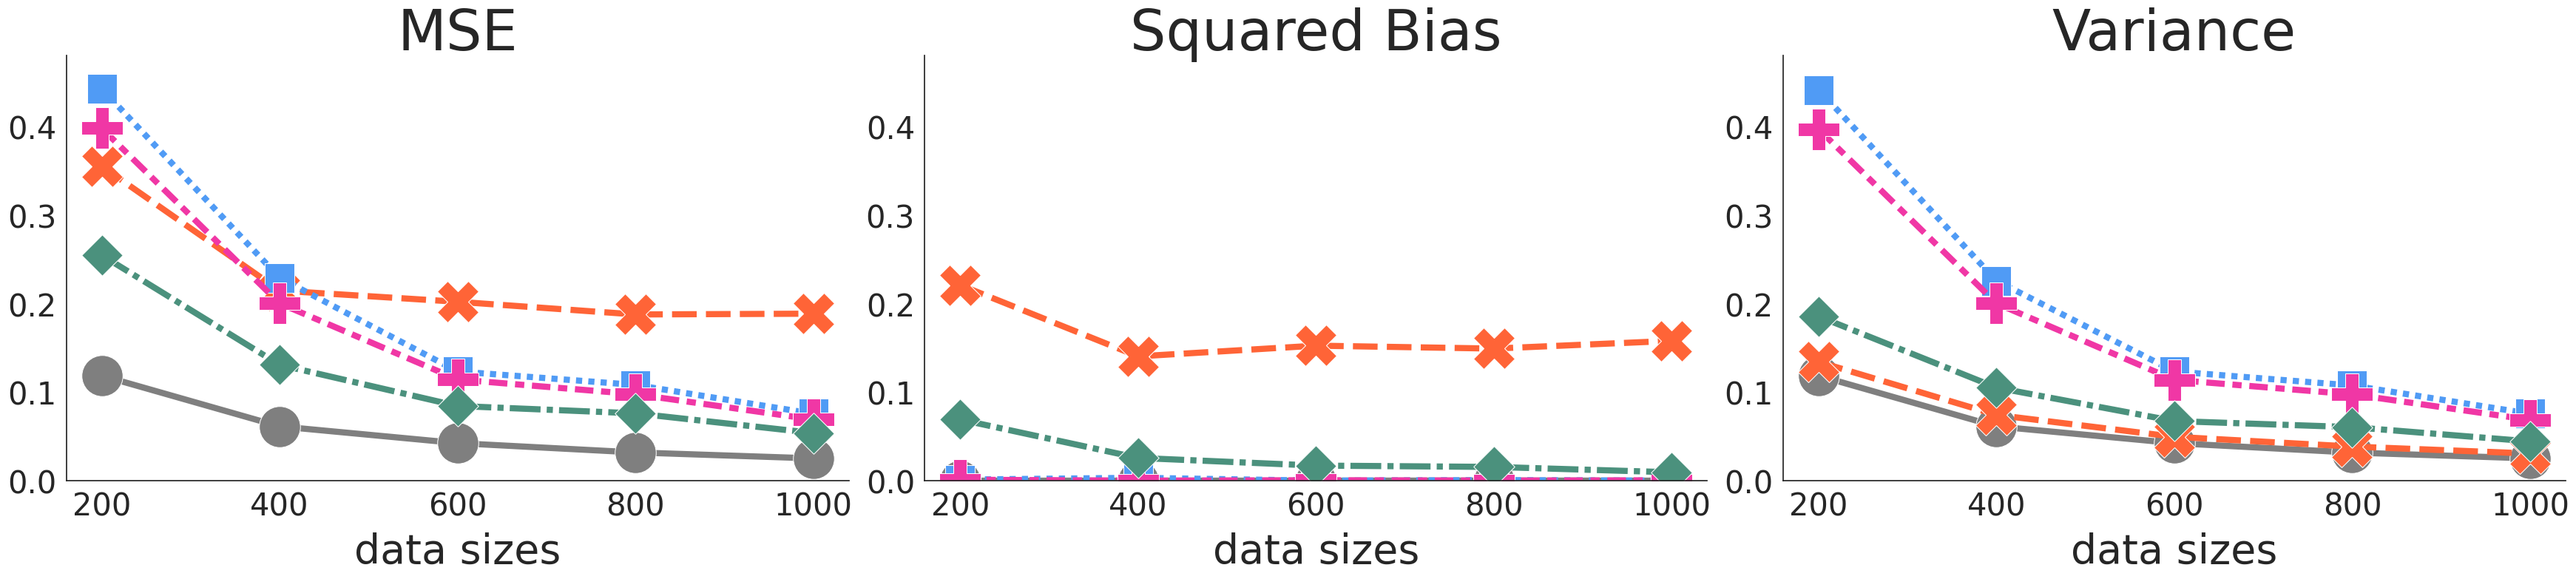

In [18]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 8), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=6,
        legend=False,
        style="est",
        x="n_data",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=palette,
        data=result_df,
    )
    ax.set_title(y_label_dict[y], fontsize=55)
    # yaxis
    ax.set_ylabel("")
    if i == 3:
        ax.set_ylim(0.8, 1.03)
    else:
        ax.set_ylim(0.0, 0.48)
    ax.tick_params(axis="y", labelsize=30)
    # xaxis
    ax.set_xlabel("data sizes", fontsize=40)
    ax.set_xticks(n_data_list)
    ax.set_xticklabels(n_data_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)